In [2]:
import pandas as pd
import numpy as np
import math
import gzip
import psycopg2
import yaml
import urllib.request
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import RemoveStereochemistry
from rdkit.Chem.SaltRemover import SaltRemover

## ChEMBL internal database conn

In [3]:
# ChEMBL target to Uniprot mapping
CHEMBL_VERSION = 32
url = fr"ftp://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/releases/chembl_{CHEMBL_VERSION}/chembl_uniprot_mapping.txt"

with urllib.request.urlopen(url) as response:
    uniprot_map = pd.read_csv(response, sep="\t", skiprows=[0], names=["UniprotID", "chembl_targets", "description", "type"])
    # Single proteins only
    uniprot_map = uniprot_map[uniprot_map["type"] == "SINGLE PROTEIN"]

In [4]:
# Open conn file
conn_dict = yaml.safe_load(open('db_conn_login.yaml'))

In [5]:
def get_chembl_assay_data_from_targets(target_uniprot_id, uniprot_map):
    """
    A function for pulling back ChEMBL assay data from an ChEMBL32 internal database given target ChEMBL ID

    Parameters
    ----------
        target_uniprot_id: String
            Uniprot ID of target
        uniprot_map: Pandas DataFrame
            Uniprot to ChEMBL ID mapping file

    Returns
    -------
        chembl_dataset
            Pandas DataFrame
    """

    target = uniprot_map[uniprot_map["UniprotID"] == target_uniprot_id]["chembl_targets"].tolist()

    if len(target) == 1:
        connection = psycopg2.connect(user=conn_dict['CHEMBL']['username'], password=conn_dict['CHEMBL']['password'], host="uk1us064-1.corpnet2.com", port="5430", database="chembl_latest")
        
        query_for_assays = """
        SELECT assay_type.assay_type, assay_type.assay_desc, assays.assay_id, target_dictionary.chembl_id, activities.text_value, activities.molregno, activities.relation, activities.type, activities.value, activities.pchembl_value, activities.units, activities.standard_relation, 
        activities.standard_type, activities.standard_value, activities.standard_units, activities.activity_comment, activities.data_validity_comment, assays.assay_organism, assays.assay_strain, assays.assay_tissue, assays.assay_cell_type,
        target_dictionary.target_type, target_dictionary.pref_name, target_dictionary.organism, compound_structures.canonical_smiles
        FROM activities
            LEFT JOIN assays ON assays.assay_id=activities.assay_id
            LEFT JOIN target_dictionary ON target_dictionary.tid=assays.tid
            LEFT JOIN assay_type ON assay_type.assay_type=assays.assay_type
            LEFT JOIN compound_structures ON compound_structures.molregno=activities.molregno
        WHERE
            activities.pchembl_value IS NOT NULL AND
            target_dictionary.chembl_id = '{0}'
        """.format(target[0])

        chembl_dataset = pd.read_sql_query(query_for_assays, con=connection)
        connection.close()

        return chembl_dataset

    else:
        raise ValueError("Uniprot ID contains more than one ChEMBL target ID or no target ID")

In [6]:
def group_clean_data(assay_data, target_name):
    """
    To group data by SMILES and get average pChEMBL value. Data kept if standard deviation was less than 0.5 and bigger than -0.5

    Parameters
    ----------
        assay_data: Pandas DataFrame
            Containing pChEMBL values (as column pchembl_value) and SMILES (as canonical_smiles) to be grouped
        target_name: String
            Name of target to be added to new target column for easy identification

    Returns
    -------
        assay_data_clean: Pandas DataFrame
            Containing average pChEMBL value per SMILES 
    """

    df_grouped = assay_data.groupby(['canonical_smiles'], as_index=False).agg({'pchembl_value':['mean','std'],'canonical_smiles':'first'})
    df_grouped.columns = ['pchembl_value'+'_mean', 'pchembl_value'+'_stddev','canonical_smiles']
    df_grouped = df_grouped.reindex(columns=sorted(df_grouped.columns))

    # Remove any large stddevs
    assay_data_clean = df_grouped[((df_grouped['pchembl_value'+'_stddev'] <= 0.5) & (df_grouped['pchembl_value'+'_stddev'] >= -0.5)) | (df_grouped['pchembl_value'+'_stddev'].isna())].copy()
    assay_data_clean['target'] = target_name

    return assay_data_clean


In [7]:
def clean_mols(input_df):
    """
    Clean DataFrame containing SMILES column to create new SMILES_clean column

    Parameters
    ----------
        input_df: Pandas DataFrame
            Input DataFrame containing column with the heading "SMILES" to be cleaned for salts and stereochemistry
    
    Returns
    -------
        input_df_clean
            Pandas DataFrame with cleaned SMILES
    """

    def moltosmiles(row):
        mol = Chem.MolFromSmiles(row["SMILES"])
        if mol:
            return Chem.MolToSmiles(mol, isomericSmiles=False)
        else:
            return None
            
    input_df["SMILES_clean"] = input_df.apply(lambda row: moltosmiles(row), axis=1)

    return input_df

## Task 2

### BET proteins (BRD2, BRD3, BRD4, BRDT)

In [17]:
BRD2_chembl_data = get_chembl_assay_data_from_targets(target_uniprot_id="P25440", uniprot_map=uniprot_map)
BRD3_chembl_data = get_chembl_assay_data_from_targets(target_uniprot_id="Q15059", uniprot_map=uniprot_map)
BRD4_chembl_data = get_chembl_assay_data_from_targets(target_uniprot_id="O60885", uniprot_map=uniprot_map)
BRDT_chembl_data = get_chembl_assay_data_from_targets(target_uniprot_id="Q58F21", uniprot_map=uniprot_map)

In [43]:
BET_data = pd.concat([group_clean_data(BRD2_chembl_data, target_name="BRD2"), group_clean_data(BRD3_chembl_data, target_name="BRD3"), group_clean_data(BRD4_chembl_data, target_name="BRD4"), group_clean_data(BRDT_chembl_data, target_name="BRDT")], ignore_index=True)
BET_data.to_csv("Benchmarking_Tasks/Task2/BET_data.csv", index=False)


In [18]:
BRD2_chembl_data_actives = BRD2_chembl_data[BRD2_chembl_data['pchembl_value'] > 7]
BRD3_chembl_data_actives = BRD3_chembl_data[BRD3_chembl_data['pchembl_value'] > 7]
BRD4_chembl_data_actives = BRD4_chembl_data[BRD4_chembl_data['pchembl_value'] > 7]
BRDT_chembl_data_actives = BRDT_chembl_data[BRDT_chembl_data['pchembl_value'] > 7]

BRD2_chembl_data_inactives = BRD2_chembl_data[BRD2_chembl_data['pchembl_value'] < 5]
BRD3_chembl_data_inactives = BRD3_chembl_data[BRD3_chembl_data['pchembl_value'] < 5]
BRD4_chembl_data_inactives = BRD4_chembl_data[BRD4_chembl_data['pchembl_value'] < 5]
BRDT_chembl_data_inactives = BRDT_chembl_data[BRDT_chembl_data['pchembl_value'] < 5]

In [19]:
BRD2_data_clean = group_clean_data(BRD2_chembl_data_actives, target_name='BRD2')
BRD3_data_clean = group_clean_data(BRD3_chembl_data_actives, target_name='BRD3')
BRD4_data_clean = group_clean_data(BRD4_chembl_data_actives, target_name='BRD4')
BRDT_data_clean = group_clean_data(BRDT_chembl_data_actives, target_name='BRDT')

BRD2_data_clean_inactives = group_clean_data(BRD2_chembl_data_inactives, target_name='BRD2')
BRD3_data_clean_inactives = group_clean_data(BRD3_chembl_data_inactives, target_name='BRD3')
BRD4_data_clean_inactives = group_clean_data(BRD4_chembl_data_inactives, target_name='BRD4')
BRDT_data_clean_inactives = group_clean_data(BRDT_chembl_data_inactives, target_name='BRDT')


In [30]:
print("ChEMBL compounds for BRD2:",len(group_clean_data(BRD2_chembl_data, target_name='BRD2')))
print("ChEMBL compounds for BRD3:",len(group_clean_data(BRD3_chembl_data, target_name='BRD3')))
print("ChEMBL compounds for BRD4:",len(group_clean_data(BRD4_chembl_data, target_name='BRD4')))
print("ChEMBL compounds for BRDT:",len(group_clean_data(BRDT_chembl_data, target_name='BRDT')))
print("\n")
print("Active ChEMBL compounds for BRD2:",len(BRD2_data_clean))
print("Active ChEMBL compounds for BRD3:",len(BRD3_data_clean))
print("Active ChEMBL compounds for BRD4:",len(BRD4_data_clean))
print("Active ChEMBL compounds for BRDT:",len(BRDT_data_clean))
print("\n")
print("Inctive ChEMBL compounds for BRD2:",len(BRD2_data_clean_inactives))
print("Inctive ChEMBL compounds for BRD3:",len(BRD3_data_clean_inactives))
print("Inctive ChEMBL compounds for BRD4:",len(BRD4_data_clean_inactives))
print("Inctive ChEMBL compounds for BRDT:",len(BRDT_data_clean_inactives))

ChEMBL compounds for BRD2: 415
ChEMBL compounds for BRD3: 398
ChEMBL compounds for BRD4: 3674
ChEMBL compounds for BRDT: 120


Active ChEMBL compounds for BRD2: 179
Active ChEMBL compounds for BRD3: 187
Active ChEMBL compounds for BRD4: 1580
Active ChEMBL compounds for BRDT: 41


Inctive ChEMBL compounds for BRD2: 76
Inctive ChEMBL compounds for BRD3: 48
Inctive ChEMBL compounds for BRD4: 680
Inctive ChEMBL compounds for BRDT: 28


In [21]:
# 21 actives across BRD2, BRD3, BRD4, BRDT
BET_active = BRD2_data_clean.merge(BRD3_data_clean,on='canonical_smiles').merge(BRD4_data_clean,on='canonical_smiles').merge(BRDT_data_clean,on='canonical_smiles')
BET_active

,canonical_smiles,pchembl_value_mean_x,pchembl_value_stddev_x,target_x,pchembl_value_mean_y,pchembl_value_stddev_y,target_y,pchembl_value_mean_x,pchembl_value_stddev_x,target_x,pchembl_value_mean_y,pchembl_value_stddev_y,target_y
0,CCNC(=O)C[C@@H]1N=C(c2ccc(Cl)cc2)c2cc(OC)ccc2-...,7.352500,0.160957,BRD2,7.331667,0.204887,BRD3,7.337941,0.184322,BRD4,7.220000,NaN,BRDT
1,CCS(=O)(=O)Cc1cnc(Oc2ccc(F)cc2F)c(-c2cc(C)c3c(...,8.890000,NaN,BRD2,9.000000,NaN,BRD3,8.632000,0.106160,BRD4,8.680000,NaN,BRDT
2,CN(C)CCN1CCN(c2nc(NCc3cccc(Cl)c3)c3cc(-c4ccc(=...,7.556667,0.070946,BRD2,7.686667,0.011547,BRD3,7.470000,0.244336,BRD4,7.435000,0.374767,BRDT
3,COCc1nc2cnc3cc(-c4c(C)noc4C)c(OC)cc3c2n1[C@H](...,7.650000,0.353553,BRD2,7.900000,0.141421,BRD3,7.700000,0.424264,BRD4,7.600000,NaN,BRDT
4,COc1cc2c(cc1-c1c(C)noc1C)[nH]c1nc(C)nc(-c3ccnc...,8.786667,0.380832,BRD2,9.000000,0.260000,BRD3,8.198889,0.481052,BRD4,8.030000,0.220681,BRDT
5,COc1cc2c(cc1-c1c(C)noc1C)[nH]c1nc(C)nc(Nc3cc(C...,9.090000,0.183848,BRD2,9.295000,0.021213,BRD3,8.820000,0.243311,BRD4,8.690000,0.014142,BRDT
6,Cc1cc(C)cc(Oc2cccc(-c3c(C)nnn3C3CCN(CCN(C)C)CC...,7.660000,NaN,BRD2,7.700000,NaN,BRD3,7.670000,0.433013,BRD4,7.820000,NaN,BRDT
7,Cc1cc2c(-c3ccco3)cnc(N[C@@H]3CCN(C)C[C@H]3C(=O...,8.050000,0.494975,BRD2,8.100000,0.424264,BRD3,7.800000,0.360555,BRD4,7.850000,0.212132,BRDT
8,Cc1nnc2n1-c1ccc(-c3ccc(N)nc3)cc1N(c1ccc(Cl)cc1...,8.520000,0.000000,BRD2,8.520000,0.000000,BRD3,8.170000,0.494975,BRD4,8.520000,0.000000,BRDT
9,Cc1noc(C)c1-c1ccc2c(c1)C(N)(c1ccccc1)C(=O)N2,7.260000,NaN,BRD2,7.460000,NaN,BRD3,7.620000,NaN,BRD4,7.020000,NaN,BRDT


In [22]:
# 130 actives across BRD2, BRD3, BRD4
BRD_active = BRD2_data_clean.merge(BRD3_data_clean,on='canonical_smiles').merge(BRD4_data_clean,on='canonical_smiles')
BRD_active

,canonical_smiles,pchembl_value_mean_x,pchembl_value_stddev_x,target_x,pchembl_value_mean_y,pchembl_value_stddev_y,target_y,pchembl_value_mean,pchembl_value_stddev,target
0,CC(=O)N1c2ccc(-c3ccc(NC(=O)CCCCCCC(=O)NO)cc3)c...,7.5000,NaN,BRD2,7.160000,NaN,BRD3,7.284000,0.026077,BRD4
1,CC(C)n1ncc2c1C(=O)N(c1cc(Cl)c(=O)n(C)c1)C2c1cc...,7.3100,NaN,BRD2,7.120000,NaN,BRD3,7.210000,NaN,BRD4
2,CCNC(=O)C[C@@H]1N=C(c2ccc(Cl)cc2)c2cc(OC)ccc2-...,7.3525,0.160957,BRD2,7.331667,0.204887,BRD3,7.337941,0.184322,BRD4
3,CCOC(=O)N1CC(n2nc(C)c3c2C(=O)N(c2cc(C)c(=O)n(C...,7.1000,NaN,BRD2,7.120000,NaN,BRD3,7.060000,NaN,BRD4
4,CCOC(=O)N1CC(n2nc(C)c3c2C(=O)N(c2cc(C)c4nnc(C)...,7.2300,NaN,BRD2,7.110000,NaN,BRD3,7.310000,NaN,BRD4
...,...,...,...,...,...,...,...,...,...,...
125,Cc1sc2c(c1C)C(c1ccc(Cl)cc1)=N[C@@H](CC(=O)OC(C...,7.6625,0.441039,BRD2,7.486000,0.470309,BRD3,7.391481,0.341232,BRD4
126,Cn1cc2c3c(c[nH]c(=O)c31)-c1cc(CS(C)(=O)=O)ccc1...,8.5900,NaN,BRD2,7.770000,NaN,BRD3,8.650000,0.188680,BRD4
127,Cn1cc2c3c(c[nH]c3c1=O)CN(c1ccc(F)cc1F)c1ccc(CS...,8.6000,NaN,BRD2,8.000000,NaN,BRD3,8.807500,0.344807,BRD4
128,Cn1cc2c3c(c[nH]c3c1=O)CN(c1ccccn1)c1ccc(CS(C)(...,9.3200,NaN,BRD2,8.000000,NaN,BRD3,8.930000,0.196808,BRD4


In [23]:
# Now let's look for BET selective compounds too
# If also shown to be inactive in at least one other target
BRD2_selective = BRD2_data_clean[~BRD2_data_clean['canonical_smiles'].isin(BRD3_data_clean['canonical_smiles'].tolist() + BRD4_data_clean['canonical_smiles'].tolist() + BRDT_data_clean['canonical_smiles'].tolist())]
BRD2_selective = BRD2_selective[BRD2_selective['canonical_smiles'].isin(BRD3_data_clean_inactives['canonical_smiles'].tolist() + BRD4_data_clean_inactives['canonical_smiles'].tolist() + BRDT_data_clean_inactives['canonical_smiles'].tolist())]
BRD2_selective

,canonical_smiles,pchembl_value_mean,pchembl_value_stddev,target
15,CCNC(=O)c1cc2c(-c3cc(C(C)(C)O)ccc3Oc3c(C)cc(F)...,8.69,0.494975,BRD2


In [24]:
BRD3_selective = BRD3_data_clean[~BRD3_data_clean['canonical_smiles'].isin(BRD2_data_clean['canonical_smiles'].tolist() + BRD4_data_clean['canonical_smiles'].tolist() + BRDT_data_clean['canonical_smiles'].tolist())]
BRD3_selective = BRD3_selective[BRD3_selective['canonical_smiles'].isin(BRD2_data_clean_inactives['canonical_smiles'].tolist() + BRD4_data_clean_inactives['canonical_smiles'].tolist() + BRDT_data_clean_inactives['canonical_smiles'].tolist())]
BRD3_selective

,canonical_smiles,pchembl_value_mean,pchembl_value_stddev,target
46,CNC(=O)c1cc(C(=O)N[C@H]2CC[C@H](O)CC2)n([C@@H]...,7.1,NaN,BRD3
81,C[C@H](Oc1ccc(C(=O)NC2CC2)cc1-c1cn(C)nn1)c1ccccn1,7.1,NaN,BRD3


In [25]:
BRD4_selective = BRD4_data_clean[~BRD4_data_clean['canonical_smiles'].isin(BRD2_data_clean['canonical_smiles'].tolist() + BRD3_data_clean['canonical_smiles'].tolist() + BRDT_data_clean['canonical_smiles'].tolist())]
BRD4_selective = BRD4_selective[BRD4_selective['canonical_smiles'].isin(BRD2_data_clean_inactives['canonical_smiles'].tolist() + BRD3_data_clean_inactives['canonical_smiles'].tolist() + BRDT_data_clean_inactives['canonical_smiles'].tolist())]
BRD4_selective

,canonical_smiles,pchembl_value_mean,pchembl_value_stddev,target
559,CNC(=O)c1cc(C(=O)NC2CC2)cn(Cc2cccc3[nH]ccc23)c1=O,7.80,0.000000,BRD4
706,COc1cc(OC)c2c(=O)[nH]c(-c3cc(C)c(OCCO)c(C)c3)n...,7.31,0.122882,BRD4
821,COc1ccccc1S(=O)(=O)Nc1ccc2c3c(cc(-n4cnc(C)c4)n...,7.06,NaN,BRD4
1050,Cc1ccc(C(C)C)cc1Oc1nccc(-c2c(-c3ccc(C(F)(F)F)c...,7.92,NaN,BRD4
1407,Cc1noc(C)c1-c1ccccc1,7.30,NaN,BRD4


In [44]:
BRDT_selective = BRDT_data_clean[~BRDT_data_clean['canonical_smiles'].isin(BRD2_data_clean['canonical_smiles'].tolist() + BRD3_data_clean['canonical_smiles'].tolist() + BRD4_data_clean['canonical_smiles'].tolist())]
BRDT_selective = BRDT_selective[BRDT_selective['canonical_smiles'].isin(BRD2_data_clean_inactives['canonical_smiles'].tolist() + BRD3_data_clean_inactives['canonical_smiles'].tolist() + BRD4_data_clean_inactives['canonical_smiles'].tolist())]
BRDT_selective

,canonical_smiles,pchembl_value_mean,pchembl_value_stddev,target


### ITK/LCK/AurB active overlap

In [26]:
ITK_chembl_data = get_chembl_assay_data_from_targets(target_uniprot_id="Q08881", uniprot_map=uniprot_map)
LCK_chembl_data = get_chembl_assay_data_from_targets(target_uniprot_id="P06239", uniprot_map=uniprot_map)
AurB_chembl_data = get_chembl_assay_data_from_targets(target_uniprot_id="Q96GD4", uniprot_map=uniprot_map)

In [45]:
ITK_LCK_AurB_data = pd.concat([group_clean_data(ITK_chembl_data, target_name="ITK"), group_clean_data(LCK_chembl_data, target_name="LCK"), group_clean_data(AurB_chembl_data, target_name="AurB")], ignore_index=True)
ITK_LCK_AurB_data.to_csv("Benchmarking_Tasks/Task2/ITK_LCK_AurB_data.csv", index=False)


In [27]:
ITK_chembl_data_actives = ITK_chembl_data[ITK_chembl_data['pchembl_value'] > 7]
LCK_chembl_data_actives = LCK_chembl_data[LCK_chembl_data['pchembl_value'] > 7]
AurB_chembl_data_actives = AurB_chembl_data[AurB_chembl_data['pchembl_value'] > 7]

ITK_chembl_data_inactives = ITK_chembl_data[ITK_chembl_data['pchembl_value'] < 5]
LCK_chembl_data_inactives = LCK_chembl_data[LCK_chembl_data['pchembl_value'] < 5]
AurB_chembl_data_inactives = AurB_chembl_data[AurB_chembl_data['pchembl_value'] < 5]

In [28]:
ITK_data_clean = group_clean_data(ITK_chembl_data_actives, target_name='ITK')
LCK_data_clean = group_clean_data(LCK_chembl_data_actives, target_name='LCK')
AurB_data_clean = group_clean_data(AurB_chembl_data_actives, target_name='AurB')

ITK_data_clean_inactives = group_clean_data(ITK_chembl_data_inactives, target_name='ITK')
LCK_data_clean_inactives = group_clean_data(LCK_chembl_data_inactives, target_name='LCK')
AurB_data_clean_inactives = group_clean_data(AurB_chembl_data_inactives, target_name='AurB')


In [31]:
print("ChEMBL compounds for ITK:",len(group_clean_data(ITK_chembl_data, target_name='ITK')))
print("ChEMBL compounds for LCK:",len(group_clean_data(LCK_chembl_data, target_name='LCK')))
print("ChEMBL compounds for AurB:",len(group_clean_data(AurB_chembl_data, target_name='AurB')))
print("\n")
print("Active ChEMBL compounds for ITK:",len(ITK_data_clean))
print("Active ChEMBL compounds for LCK:",len(LCK_data_clean))
print("Active ChEMBL compounds for AurB:",len(AurB_data_clean))
print("\n")
print("Inctive ChEMBL compounds for ITK:",len(ITK_data_clean_inactives))
print("Inctive ChEMBL compounds for LCK:",len(LCK_data_clean_inactives))
print("Inctive ChEMBL compounds for AurB:",len(AurB_data_clean_inactives))

ChEMBL compounds for ITK: 833
ChEMBL compounds for LCK: 1987
ChEMBL compounds for AurB: 2335


Active ChEMBL compounds for ITK: 499
Active ChEMBL compounds for LCK: 797
Active ChEMBL compounds for AurB: 1076


Inctive ChEMBL compounds for ITK: 52
Inctive ChEMBL compounds for LCK: 155
Inctive ChEMBL compounds for AurB: 128


In [11]:
pan_ITK_LCK_AurB_active = ITK_data_clean.merge(LCK_data_clean,on='canonical_smiles').merge(AurB_data_clean,on='canonical_smiles')
pan_ITK_LCK_AurB_active

,canonical_smiles,pchembl_value_mean_x,pchembl_value_stddev_x,target_x,pchembl_value_mean_y,pchembl_value_stddev_y,target_y,pchembl_value_mean,pchembl_value_stddev,target
0,CN1CCN(c2ccc3nc(-c4c(N)c5c(F)cccc5[nH]c4=O)[nH...,7.30,NaN,ITK,7.700000,NaN,LCK,7.100000,NaN,AurB
1,CNC1CC2OC(C)(C1OC)n1c3ccccc3c3c4c(c5c6ccccc6n2...,8.10,NaN,ITK,7.600000,NaN,LCK,8.700000,NaN,AurB
2,COc1cc(Nc2ncc([N+](=O)[O-])c(Nc3ccccc3C(N)=O)n...,7.80,NaN,ITK,7.400000,NaN,LCK,8.200000,NaN,AurB
3,Cc1cc(Nc2cc(N3CCN(C)CC3)nc(Sc3ccc(NC(=O)C4CC4)...,7.20,NaN,ITK,7.173333,0.063509,LCK,7.833846,0.361704,AurB
4,Cc1cccc(NC(=O)Nc2ccc(-c3csc4c(-c5cn[nH]c5)cnc(...,7.40,NaN,ITK,7.500000,NaN,LCK,8.085000,0.021213,AurB
5,Cc1cccc(NC(=O)Nc2ccc(-c3csc4c(-c5cnn(C)c5)cnc(...,7.60,NaN,ITK,9.000000,NaN,LCK,7.800000,NaN,AurB
6,Cc1cnc(Nc2cc(Cc3ccccc3)nc(N[C@H]3CC[C@H](O)CC3...,8.70,NaN,ITK,7.700000,NaN,LCK,9.300000,NaN,AurB
7,Cn1cc(-c2cnc(N)c3c(-c4ccc(NC(=O)Nc5cccc(F)c5)c...,7.80,NaN,ITK,8.800000,NaN,LCK,8.050000,NaN,AurB
8,Cn1cc(-c2cnc3c(-c4csc(C(=O)N[C@@H]5CCCC[C@@H]5...,7.58,NaN,ITK,8.410000,NaN,LCK,7.550000,NaN,AurB
9,N#Cc1ccc2nc(Nc3cc(Cc4ccccc4)nc(N[C@H]4CC[C@H](...,9.60,NaN,ITK,7.200000,NaN,LCK,7.100000,NaN,AurB


In [12]:
# Now let's look for selective inhibitors
# If inactive in at least one target
ITK_selective = ITK_data_clean[~ITK_data_clean['canonical_smiles'].isin(LCK_data_clean['canonical_smiles'].tolist() + AurB_data_clean['canonical_smiles'].tolist())]
ITK_selective = ITK_selective[ITK_selective['canonical_smiles'].isin(LCK_data_clean_inactives['canonical_smiles'].tolist() + AurB_data_clean_inactives['canonical_smiles'].tolist())]
ITK_selective

,canonical_smiles,pchembl_value_mean,pchembl_value_stddev,target


In [16]:
ITK_LCK_selective = ITK_data_clean[~ITK_data_clean['canonical_smiles'].isin(LCK_data_clean['canonical_smiles'].tolist())]
ITK_LCK_selective = ITK_LCK_selective[ITK_LCK_selective['canonical_smiles'].isin(LCK_data_clean_inactives['canonical_smiles'].tolist())]
ITK_LCK_selective


,canonical_smiles,pchembl_value_mean,pchembl_value_stddev,target


In [14]:
ITK_AurB_selective = LCK_data_clean[~LCK_data_clean['canonical_smiles'].isin(AurB_data_clean['canonical_smiles'].tolist())]
ITK_AurB_selective = ITK_AurB_selective[ITK_AurB_selective['canonical_smiles'].isin(AurB_data_clean_inactives['canonical_smiles'].tolist())]
ITK_AurB_selective

,canonical_smiles,pchembl_value_mean,pchembl_value_stddev,target


### JAK1, JAK2, JAK3, and TYK2 active overlap

In [32]:
JAK1_chembl_data = get_chembl_assay_data_from_targets(target_uniprot_id="P23458", uniprot_map=uniprot_map)
JAK2_chembl_data = get_chembl_assay_data_from_targets(target_uniprot_id="O60674", uniprot_map=uniprot_map)
JAK3_chembl_data = get_chembl_assay_data_from_targets(target_uniprot_id="P52333", uniprot_map=uniprot_map)
TYK2_chembl_data = get_chembl_assay_data_from_targets(target_uniprot_id="P29597", uniprot_map=uniprot_map)

In [46]:
JAK_TYK_data = pd.concat([group_clean_data(JAK1_chembl_data, target_name="JAK1"), group_clean_data(JAK2_chembl_data, target_name="JAK2"), group_clean_data(JAK3_chembl_data, target_name="JAK3"), group_clean_data(TYK2_chembl_data, target_name="TYK2")], ignore_index=True)
JAK_TYK_data.to_csv("Benchmarking_Tasks/Task2/JAK_TYK2_data.csv", index=False)

In [33]:
JAK1_chembl_data_actives = JAK1_chembl_data[JAK1_chembl_data['pchembl_value'] > 7]
JAK2_chembl_data_actives = JAK2_chembl_data[JAK2_chembl_data['pchembl_value'] > 7]
JAK3_chembl_data_actives = JAK3_chembl_data[JAK3_chembl_data['pchembl_value'] > 7]
TYK2_chembl_data_actives = TYK2_chembl_data[TYK2_chembl_data['pchembl_value'] > 7]

JAK1_chembl_data_inactives = JAK1_chembl_data[JAK1_chembl_data['pchembl_value'] < 5]
JAK2_chembl_data_inactives = JAK2_chembl_data[JAK2_chembl_data['pchembl_value'] < 5]
JAK3_chembl_data_inactives = JAK3_chembl_data[JAK3_chembl_data['pchembl_value'] < 5]
TYK2_chembl_data_inactives = TYK2_chembl_data[TYK2_chembl_data['pchembl_value'] < 5]

In [34]:
JAK1_data_clean = group_clean_data(JAK1_chembl_data_actives, target_name='JAK1')
JAK2_data_clean = group_clean_data(JAK2_chembl_data_actives, target_name='JAK2')
JAK3_data_clean = group_clean_data(JAK3_chembl_data_actives, target_name='JAK3')
TYK2_data_clean = group_clean_data(TYK2_chembl_data_actives, target_name='TYK2')

JAK1_data_clean_inactives = group_clean_data(JAK1_chembl_data_inactives, target_name='JAK1')
JAK2_data_clean_inactives = group_clean_data(JAK2_chembl_data_inactives, target_name='JAK2')
JAK3_data_clean_inactives = group_clean_data(JAK3_chembl_data_inactives, target_name='JAK3')
TYK2_data_clean_inactives = group_clean_data(TYK2_chembl_data_inactives, target_name='TYK2')

In [35]:
print("ChEMBL compounds for JAK1:",len(group_clean_data(JAK1_chembl_data, target_name='JAK1')))
print("ChEMBL compounds for JAK2:",len(group_clean_data(JAK2_chembl_data, target_name='JAK2')))
print("ChEMBL compounds for JAK2:",len(group_clean_data(JAK3_chembl_data, target_name='JAK3')))
print("ChEMBL compounds for TYK2:",len(group_clean_data(TYK2_chembl_data, target_name='TYK2')))
print("\n")
print("Active ChEMBL compounds for JAK1:",len(JAK1_data_clean))
print("Active ChEMBL compounds for JAK2:",len(JAK2_data_clean))
print("Active ChEMBL compounds for JAK3:",len(JAK3_data_clean))
print("Active ChEMBL compounds for TYK2:",len(TYK2_data_clean))
print("\n")
print("Inctive ChEMBL compounds for JAK1:",len(JAK1_data_clean_inactives))
print("Inctive ChEMBL compounds for JAK2:",len(JAK2_data_clean_inactives))
print("Inctive ChEMBL compounds for JAK3:",len(JAK3_data_clean_inactives))
print("Inctive ChEMBL compounds for TYK2:",len(TYK2_data_clean_inactives))

ChEMBL compounds for JAK1: 4306
ChEMBL compounds for JAK2: 5993
ChEMBL compounds for JAK2: 3509
ChEMBL compounds for TYK2: 1557


Active ChEMBL compounds for JAK1: 3621
Active ChEMBL compounds for JAK2: 3885
Active ChEMBL compounds for JAK3: 1690
Active ChEMBL compounds for TYK2: 726


Inctive ChEMBL compounds for JAK1: 34
Inctive ChEMBL compounds for JAK2: 145
Inctive ChEMBL compounds for JAK3: 84
Inctive ChEMBL compounds for TYK2: 21


In [10]:
# Pan-JAK/TYK2 activity
JAK_active = JAK1_data_clean.merge(JAK2_data_clean,on='canonical_smiles').merge(JAK3_data_clean,on='canonical_smiles')
JAK_active

,canonical_smiles,pchembl_value_mean_x,pchembl_value_stddev_x,target_x,pchembl_value_mean_y,pchembl_value_stddev_y,target_y,pchembl_value_mean,pchembl_value_stddev,target
0,Br.NC(=O)c1cnc2[nH]ccc2c1NC1C2CC3CC1CC(O)(C3)C2,8.41,NaN,JAK1,8.30,NaN,JAK2,9.15,NaN,JAK3
1,BrC[C@H]1CC[C@H](c2nnn3cnc4[nH]ccc4c23)CC1,9.40,NaN,JAK1,8.52,NaN,JAK2,7.13,NaN,JAK3
2,Brc1ccc(CN2CCC(c3nnn4cnc5[nH]ccc5c34)CC2)cc1,8.96,NaN,JAK1,8.21,NaN,JAK2,7.38,NaN,JAK3
3,Brc1ccc(CN2CCC(c3nnn4cnc5[nH]ccc5c34)CC2)o1,8.85,NaN,JAK1,8.55,NaN,JAK2,7.22,NaN,JAK3
4,Brc1ccc(CN2CCC(c3nnn4cnc5[nH]ccc5c34)CC2)s1,9.10,NaN,JAK1,8.34,NaN,JAK2,7.26,NaN,JAK3
...,...,...,...,...,...,...,...,...,...,...
456,[N-]=[N+]=NC[C@H]1CC[C@H](c2nnn3cnc4[nH]ccc4c2...,9.48,NaN,JAK1,8.77,NaN,JAK2,7.32,NaN,JAK3
457,c1cc2c(ncn3cnc(C4CCCCC4)c23)[nH]1,7.85,NaN,JAK1,7.77,NaN,JAK2,7.21,NaN,JAK3
458,c1cc2c(ncn3nnc(C4CCCCCC4)c23)[nH]1,8.48,NaN,JAK1,7.89,NaN,JAK2,7.07,NaN,JAK3
459,c1cc2c(ncn3nnc(C4CCN(Cc5cncs5)CC4)c23)[nH]1,8.31,NaN,JAK1,7.89,NaN,JAK2,7.38,NaN,JAK3


In [11]:
JAK_TYK2_active = JAK1_data_clean.merge(JAK2_data_clean,on='canonical_smiles').merge(JAK3_data_clean,on='canonical_smiles').merge(TYK2_data_clean,on='canonical_smiles')
JAK_TYK2_active

,canonical_smiles,pchembl_value_mean_x,pchembl_value_stddev_x,target_x,pchembl_value_mean_y,pchembl_value_stddev_y,target_y,pchembl_value_mean_x,pchembl_value_stddev_x,target_x,pchembl_value_mean_y,pchembl_value_stddev_y,target_y
0,Br.NC(=O)c1cnc2[nH]ccc2c1NC1C2CC3CC1CC(O)(C3)C2,8.41,NaN,JAK1,8.30,NaN,JAK2,9.15,NaN,JAK3,8.32,NaN,TYK2
1,BrC[C@H]1CC[C@H](c2nnn3cnc4[nH]ccc4c23)CC1,9.40,NaN,JAK1,8.52,NaN,JAK2,7.13,NaN,JAK3,8.59,NaN,TYK2
2,Brc1ccc(CN2CCC(c3nnn4cnc5[nH]ccc5c34)CC2)o1,8.85,NaN,JAK1,8.55,NaN,JAK2,7.22,NaN,JAK3,7.01,NaN,TYK2
3,CC(=O)N1CCC(Cc2cccc3cnc(Nc4cnn(C)c4)nc23)CC1,7.20,NaN,JAK1,7.90,NaN,JAK2,7.70,NaN,JAK3,7.10,NaN,TYK2
4,CC(=O)N1CCC2(CCC(Nc3nc(Nc4cnn(C)c4)ncc3Cl)CC2)CC1,9.05,NaN,JAK1,8.40,NaN,JAK2,7.33,NaN,JAK3,8.40,NaN,TYK2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,O[C@@H](CNC[C@H]1CC[C@H](c2nnn3cnc4[nH]ccc4c23...,8.54,NaN,JAK1,7.31,NaN,JAK2,7.20,NaN,JAK3,7.50,NaN,TYK2
190,SC[C@H]1CC[C@H](c2nnn3cnc4[nH]ccc4c23)CC1,9.48,NaN,JAK1,8.66,NaN,JAK2,7.52,NaN,JAK3,8.01,NaN,TYK2
191,[N-]=[N+]=NC[C@H]1CC[C@H](c2nnn3cnc4[nH]ccc4c2...,9.48,NaN,JAK1,8.77,NaN,JAK2,7.32,NaN,JAK3,8.04,NaN,TYK2
192,c1cc2c(ncn3cnc(C4CCCCC4)c23)[nH]1,7.85,NaN,JAK1,7.77,NaN,JAK2,7.21,NaN,JAK3,7.23,NaN,TYK2


In [59]:
# Selective compounds JAK
JAK1_selective = JAK1_data_clean[~JAK1_data_clean['canonical_smiles'].isin(JAK2_data_clean['canonical_smiles'].tolist() + JAK3_data_clean['canonical_smiles'].tolist())]
JAK1_selective = JAK1_selective[JAK1_selective['canonical_smiles'].isin(JAK2_data_clean_inactives['canonical_smiles'].tolist() + JAK3_data_clean_inactives['canonical_smiles'].tolist())]
JAK1_selective

,canonical_smiles,pchembl_value_mean,pchembl_value_stddev,target
40,CC(=O)N1CCN(c2cc(Nc3ncc(C)c(Nc4cccc(CO)c4)n3)c...,8.000,NaN,JAK1
479,CCCCS(=O)(=O)N[C@H]1C[C@@H](N(C)c2ncnc3[nH]ccc...,7.920,NaN,JAK1
1150,CN(c1ncnc2[nH]ccc12)[C@H]1C[C@@H](NS(=O)(=O)N2...,7.850,NaN,JAK1
1164,CN(c1ncnc2[nH]ccc12)[C@H]1C[C@@H](NS(C)(=O)=O)C1,7.050,NaN,JAK1
1509,COc1ccc(-c2nc3c(NCC4CCNCC4)c(Cl)cnc3[nH]2)c(F)c1,7.470,NaN,JAK1
1539,COc1ccc(F)c(-c2nc3c(NCC4CCNCC4)c(Cl)cnc3[nH]2)c1,7.215,0.13435,JAK1
1861,Cc1[nH]nc2[nH]c(=O)cc(C3CCCC3)c12,7.140,NaN,JAK1
1863,Cc1[nH]nc2[nH]c(=O)cc([C@@H]3C[C@@H]4C[C@H]3C[...,7.520,NaN,JAK1
1873,Cc1[nH]nc2[nH]c(=O)cc([C@H]3CC[C@H](CCC#N)CC3)c12,7.500,NaN,JAK1
1878,Cc1[nH]nc2[nH]c(=O)cc([C@H]3C[C@H]4CC[C@@H]3C4...,7.340,NaN,JAK1


In [60]:
# Selective compounds JAK
JAK2_selective = JAK2_data_clean[~JAK2_data_clean['canonical_smiles'].isin(JAK1_data_clean['canonical_smiles'].tolist() + JAK3_data_clean['canonical_smiles'].tolist())]
JAK2_selective = JAK2_selective[JAK2_selective['canonical_smiles'].isin(JAK1_data_clean_inactives['canonical_smiles'].tolist() + JAK3_data_clean_inactives['canonical_smiles'].tolist())]
JAK2_selective

,canonical_smiles,pchembl_value_mean,pchembl_value_stddev,target
154,CC(C)(C)NS(=O)(=O)c1ccc(-c2cc3c(N)ncc(C(=O)NCC...,8.30,NaN,JAK2
316,CC(C)Oc1cc(Nc2cncc(N[C@@H](C)c3ccc(F)cn3)n2)n[...,8.00,NaN,JAK2
1567,COc1cc(Nc2nc(N[C@@H](C)c3ncc(F)cn3)c(F)c(N3CCO...,7.43,NaN,JAK2
1569,COc1cc(Nc2nc(N[C@@H](C)c3ncc(F)cn3)nc(N3CCOCC3...,8.25,0.212132,JAK2
1700,COc1ccc2c(Nc3cn(C)cn3)nc(NC(C)c3ncc(F)cn3)nc2c1,7.62,NaN,JAK2
2043,C[C@H](Nc1nc(Nc2cc(C3CC3)[nH]n2)cnc1C#N)c1ccc(...,7.60,NaN,JAK2
2045,C[C@H](Nc1nc(Nc2cn(C)cn2)c2ccccc2n1)c1ncc(F)cn1,8.52,NaN,JAK2
2158,Cc1cc(Nc2cnc(C#N)c(NC(C)c3ccc(F)cn3)n2)n[nH]1,8.30,NaN,JAK2
2162,Cc1cc(Nc2cncc(N[C@@H](C)c3ccc(F)cn3)n2)n[nH]1,8.52,NaN,JAK2
2163,Cc1cc(Nc2cncc(N[C@@H](C)c3ncc(F)cn3)n2)n[nH]1,8.52,0.000000,JAK2


In [61]:
# Selective compounds JAK
JAK3_selective = JAK3_data_clean[~JAK3_data_clean['canonical_smiles'].isin(JAK1_data_clean['canonical_smiles'].tolist() + JAK2_data_clean['canonical_smiles'].tolist())]
JAK3_selective = JAK3_selective[JAK3_selective['canonical_smiles'].isin(JAK1_data_clean_inactives['canonical_smiles'].tolist() + JAK2_data_clean_inactives['canonical_smiles'].tolist())]
JAK3_selective

,canonical_smiles,pchembl_value_mean,pchembl_value_stddev,target
311,CC(=O)N[C@@H]1CCc2ccc(Oc3cnc4[nH]cc(C(=O)N[C@H...,7.85,NaN,JAK3
804,CN(c1ncnc2[nH]ccc12)C1CCCCC1,7.10,NaN,JAK3


In [63]:
# JAK and TYK2 selective
JAK1_TYK_selective = JAK1_data_clean[~JAK1_data_clean['canonical_smiles'].isin(JAK2_data_clean['canonical_smiles'].tolist() + JAK3_data_clean['canonical_smiles'].tolist() + TYK2_data_clean['canonical_smiles'].tolist())]
JAK1_TYK_selective = JAK1_TYK_selective[JAK1_TYK_selective['canonical_smiles'].isin(JAK2_data_clean_inactives['canonical_smiles'].tolist() + JAK3_data_clean_inactives['canonical_smiles'].tolist() + TYK2_data_clean_inactives['canonical_smiles'].tolist())]
JAK1_TYK_selective

,canonical_smiles,pchembl_value_mean,pchembl_value_stddev,target
40,CC(=O)N1CCN(c2cc(Nc3ncc(C)c(Nc4cccc(CO)c4)n3)c...,8.000,NaN,JAK1
479,CCCCS(=O)(=O)N[C@H]1C[C@@H](N(C)c2ncnc3[nH]ccc...,7.920,NaN,JAK1
757,CN(C)C(=O)C(C#N)=Cc1ccc(-c2nc3cnc4[nH]ccc4c3n2...,7.280,NaN,JAK1
1150,CN(c1ncnc2[nH]ccc12)[C@H]1C[C@@H](NS(=O)(=O)N2...,7.850,NaN,JAK1
1164,CN(c1ncnc2[nH]ccc12)[C@H]1C[C@@H](NS(C)(=O)=O)C1,7.050,NaN,JAK1
1458,COc1cc(F)c(-c2nc3c(NCC4CCNCC4)c(Cl)cnc3[nH]2)c...,7.535,0.176777,JAK1
1509,COc1ccc(-c2nc3c(NCC4CCNCC4)c(Cl)cnc3[nH]2)c(F)c1,7.470,NaN,JAK1
1539,COc1ccc(F)c(-c2nc3c(NCC4CCNCC4)c(Cl)cnc3[nH]2)c1,7.215,0.134350,JAK1
1861,Cc1[nH]nc2[nH]c(=O)cc(C3CCCC3)c12,7.140,NaN,JAK1
1863,Cc1[nH]nc2[nH]c(=O)cc([C@@H]3C[C@@H]4C[C@H]3C[...,7.520,NaN,JAK1


In [64]:
# JAK and TYK2 selective
JAK2_TYK_selective = JAK2_data_clean[~JAK2_data_clean['canonical_smiles'].isin(JAK1_data_clean['canonical_smiles'].tolist() + JAK3_data_clean['canonical_smiles'].tolist() + TYK2_data_clean['canonical_smiles'].tolist())]
JAK2_TYK_selective = JAK2_TYK_selective[JAK2_TYK_selective['canonical_smiles'].isin(JAK1_data_clean_inactives['canonical_smiles'].tolist() + JAK3_data_clean_inactives['canonical_smiles'].tolist() + TYK2_data_clean_inactives['canonical_smiles'].tolist())]
JAK2_TYK_selective

,canonical_smiles,pchembl_value_mean,pchembl_value_stddev,target
154,CC(C)(C)NS(=O)(=O)c1ccc(-c2cc3c(N)ncc(C(=O)NCC...,8.30,NaN,JAK2
316,CC(C)Oc1cc(Nc2cncc(N[C@@H](C)c3ccc(F)cn3)n2)n[...,8.00,NaN,JAK2
1567,COc1cc(Nc2nc(N[C@@H](C)c3ncc(F)cn3)c(F)c(N3CCO...,7.43,NaN,JAK2
1569,COc1cc(Nc2nc(N[C@@H](C)c3ncc(F)cn3)nc(N3CCOCC3...,8.25,0.212132,JAK2
1700,COc1ccc2c(Nc3cn(C)cn3)nc(NC(C)c3ncc(F)cn3)nc2c1,7.62,NaN,JAK2
2043,C[C@H](Nc1nc(Nc2cc(C3CC3)[nH]n2)cnc1C#N)c1ccc(...,7.60,NaN,JAK2
2045,C[C@H](Nc1nc(Nc2cn(C)cn2)c2ccccc2n1)c1ncc(F)cn1,8.52,NaN,JAK2
2158,Cc1cc(Nc2cnc(C#N)c(NC(C)c3ccc(F)cn3)n2)n[nH]1,8.30,NaN,JAK2
2162,Cc1cc(Nc2cncc(N[C@@H](C)c3ccc(F)cn3)n2)n[nH]1,8.52,NaN,JAK2
2163,Cc1cc(Nc2cncc(N[C@@H](C)c3ncc(F)cn3)n2)n[nH]1,8.52,0.000000,JAK2


In [65]:
# JAK and TYK2 selective
JAK3_TYK_selective = JAK3_data_clean[~JAK3_data_clean['canonical_smiles'].isin(JAK1_data_clean['canonical_smiles'].tolist() + JAK2_data_clean['canonical_smiles'].tolist() + TYK2_data_clean['canonical_smiles'].tolist())]
JAK3_TYK_selective = JAK3_TYK_selective[JAK3_TYK_selective['canonical_smiles'].isin(JAK1_data_clean_inactives['canonical_smiles'].tolist() + JAK2_data_clean_inactives['canonical_smiles'].tolist() + TYK2_data_clean_inactives['canonical_smiles'].tolist())]
JAK3_TYK_selective

,canonical_smiles,pchembl_value_mean,pchembl_value_stddev,target
311,CC(=O)N[C@@H]1CCc2ccc(Oc3cnc4[nH]cc(C(=O)N[C@H...,7.85,NaN,JAK3
804,CN(c1ncnc2[nH]ccc12)C1CCCCC1,7.10,NaN,JAK3
1629,O=C1NC(=O)C(c2c[nH]c3ccccc23)=C1Nc1cccc(OC2CCN...,7.92,NaN,JAK3


In [66]:
# TYK2 selective
TYK2_selective = TYK2_data_clean[~TYK2_data_clean['canonical_smiles'].isin(JAK1_data_clean['canonical_smiles'].tolist() + JAK2_data_clean['canonical_smiles'].tolist() + JAK3_data_clean['canonical_smiles'].tolist())]
TYK2_selective = TYK2_selective[TYK2_selective['canonical_smiles'].isin(JAK1_data_clean_inactives['canonical_smiles'].tolist() + JAK2_data_clean_inactives['canonical_smiles'].tolist() + JAK3_data_clean_inactives['canonical_smiles'].tolist())]
TYK2_selective

,canonical_smiles,pchembl_value_mean,pchembl_value_stddev,target
97,CCNC(=O)c1ncc(Nc2ncc(F)c(N3C[C@H]4CC[C@H](C3)N...,7.32,NaN,TYK2


### JAK2/LCK active overlap

In [12]:
chembl_jak2_data = get_chembl_assay_data_from_targets(target_uniprot_id="O60674", uniprot_map=uniprot_map)
chembl_lck_data = get_chembl_assay_data_from_targets(target_uniprot_id="P06239", uniprot_map=uniprot_map)

jak2_chembl_data_actives = chembl_jak2_data[chembl_jak2_data['pchembl_value'] > 7]
lck_chembl_data_actives = chembl_lck_data[chembl_lck_data['pchembl_value'] > 7]

jak2_chembl_data_inactives = chembl_jak2_data[chembl_jak2_data['pchembl_value'] < 5]
lck_chembl_data_inactives = chembl_lck_data[chembl_lck_data['pchembl_value'] < 5]

In [13]:
jak2_data_clean = group_clean_data(jak2_chembl_data_actives, target_name='JAK2')
lck_data_clean = group_clean_data(lck_chembl_data_actives, target_name='LCK')

jak2_data_clean_inactives = group_clean_data(jak2_chembl_data_inactives, target_name='JAK2')
lck_data_clean_inactives = group_clean_data(lck_chembl_data_inactives, target_name='LCK')


In [14]:
# JAK2/LCK active activity
JAK_LCK_active = jak2_data_clean.merge(lck_data_clean,on='canonical_smiles')
JAK_LCK_active

,canonical_smiles,pchembl_value_mean_x,pchembl_value_stddev_x,target_x,pchembl_value_mean_y,pchembl_value_stddev_y,target_y
0,CC(Oc1cc(-c2cnn(C3CCNCC3)c2)cnc1N)c1c(Cl)ccc(F...,7.040000,NaN,JAK2,7.3000,NaN,LCK
1,CCN(CC)CCOc1ccc(Nc2ncc3cc(-c4c(Cl)cccc4Cl)c(=O...,7.400000,NaN,JAK2,8.9000,NaN,LCK
2,CCN1CCN(c2ccc(Nc3ncc(Cl)c(Nc4ccc5[nH]ncc5c4)n3...,8.600000,NaN,JAK2,7.5000,NaN,LCK
3,CN1CCN(C(=O)c2ccc3c(c2)[nH]c2c(C(N)=O)ccc(-c4c...,7.300000,NaN,JAK2,7.0900,NaN,LCK
4,CN1CCN(c2ccc(Nc3ncc(Cl)c(Nc4ccc5[nH]ncc5c4)n3)...,8.600000,NaN,JAK2,7.5000,NaN,LCK
5,CNC(=O)c1cnc(N)c2c(-c3ccc(NC(=O)Nc4cc(C)ccc4F)...,7.400000,NaN,JAK2,8.2000,NaN,LCK
6,CNC(=O)c1cnc(N)c2c(-c3ccc(NC(=O)Nc4cccc(Cl)c4)...,8.000000,NaN,JAK2,7.9000,NaN,LCK
7,CNC1CC2OC(C)(C1OC)n1c3ccccc3c3c4c(c5c6ccccc6n2...,9.100000,NaN,JAK2,7.6000,NaN,LCK
8,CNS(=O)(=O)c1ccccc1Nc1nc(Nc2cc(OC)c(OC)c(OC)c2...,9.100000,NaN,JAK2,7.1000,NaN,LCK
9,CN[C@H]1CC2OC([C@H]1OC)n1c3ccccc3c3c4c(c5c6ccc...,9.260000,NaN,JAK2,8.6600,NaN,LCK


In [16]:
# JAK2 and LCK selective
JAK2_LCK_selective = jak2_data_clean[~jak2_data_clean['canonical_smiles'].isin(lck_data_clean['canonical_smiles'].tolist())]
print(JAK2_LCK_selective)
JAK2_LCK_selective = JAK2_LCK_selective[JAK2_LCK_selective['canonical_smiles'].isin(lck_data_clean_inactives['canonical_smiles'].tolist())]
JAK2_LCK_selective

                                       canonical_smiles  pchembl_value_mean  \
0       Br.NC(=O)c1cnc2[nH]ccc2c1NC1C2CC3CC1CC(O)(C3)C2                8.30   
1            BrC[C@H]1CC[C@H](c2nnn3cnc4[nH]ccc4c23)CC1                8.52   
2         Brc1cc(CN2CCC(c3nnn4cnc5[nH]ccc5c34)CC2)sc1Br                7.15   
3          Brc1ccc(CN2CCC(c3nnn4cnc5[nH]ccc5c34)CC2)cc1                8.21   
4           Brc1ccc(CN2CCC(c3nnn4cnc5[nH]ccc5c34)CC2)o1                8.55   
...                                                 ...                 ...   
3998         c1cncc(CN2CCC(n3nnc4cnc5[nH]ccc5c43)CC2)c1                7.55   
3999          c1coc(CN2CCC(c3nnn4cnc5[nH]ccc5c34)CC2)c1                7.70   
4000          c1csc(CN2CCC(c3nnn4cnc5[nH]ccc5c34)CC2)c1                8.00   
4001          c1csc(CN2CCC(c3nnn4cnc5[nH]ccc5c34)CC2)n1                7.27   
4002  c1nc(CCNC[C@H]2CC[C@H](c3nnn4cnc5[nH]ccc5c34)C...                7.42   

      pchembl_value_stddev target  
0              

,canonical_smiles,pchembl_value_mean,pchembl_value_stddev,target


In [179]:
cols = ['chembl_id', 'relation', 'type', 'value', 'pchembl_value', 'units', 'canonical_smiles']
active_overlaps_df = pd.merge(chembl_jak2_data[chembl_jak2_data["pchembl_value"] > 8][cols], chembl_lck_data[chembl_lck_data["pchembl_value"] > 8][cols],  how='inner', on='canonical_smiles')


In [152]:
jak2_data_clean = group_clean_data(chembl_jak2_data, target_name='JAK2')
lck_data_clean = group_clean_data(chembl_lck_data, target_name='LCK')

jak2_lck_comb = pd.concat([jak2_data_clean, lck_data_clean], ignore_index=True)
jak2_lck_comb.to_csv("Benchmarking_Tasks/Task2/jak2_lck_data.csv", index=False)

In [154]:
print("Number of compounds for JAK2 with unique activity data:", len(jak2_data_clean[["pchembl_value_mean", "canonical_smiles"]].drop_duplicates()))
print("Number of active compounds (pChEMBL > 8) for JAK2 with unique activity data:", len(jak2_data_clean[jak2_data_clean["pchembl_value_mean"] > 8][["pchembl_value_mean", "canonical_smiles"]].drop_duplicates()))
print("Number of in active compounds (pChEMBL < 5) for JAK2 with unique activity data:", len(jak2_data_clean[jak2_data_clean["pchembl_value_mean"] < 5][["pchembl_value_mean", "canonical_smiles"]].drop_duplicates()))

print("Number of compounds for LCK with unique activity data:", len(lck_data_clean[["pchembl_value_mean", "canonical_smiles"]].drop_duplicates()))
print("Number of active compounds (pChEMBL > 8) for LCK with unique activity data:", len(lck_data_clean[lck_data_clean["pchembl_value_mean"] > 8][["pchembl_value_mean", "canonical_smiles"]].drop_duplicates()))
print("Number of in active compounds (pChEMBL < 5) for LCK with unique activity data:", len(lck_data_clean[lck_data_clean["pchembl_value_mean"] < 5][["pchembl_value_mean", "canonical_smiles"]].drop_duplicates()))


Number of compounds for JAK2 with unique activity data: 5993
Number of active compounds (pChEMBL > 8) for JAK2 with unique activity data: 1681
Number of in active compounds (pChEMBL < 5) for JAK2 with unique activity data: 122
Number of compounds for LCK with unique activity data: 1987
Number of active compounds (pChEMBL > 8) for LCK with unique activity data: 321
Number of in active compounds (pChEMBL < 5) for LCK with unique activity data: 151


In [156]:
active_overlaps_df["canonical_smiles"].unique()

array(['CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3c3c4c(c5c6ccccc6n2c5c31)C(=O)NC4',
       'CN[C@H]1CC2OC([C@H]1OC)n1c3ccccc3c3c4c(c5c6ccccc6n2c5c31)C(O)=NC4'],
      dtype=object)

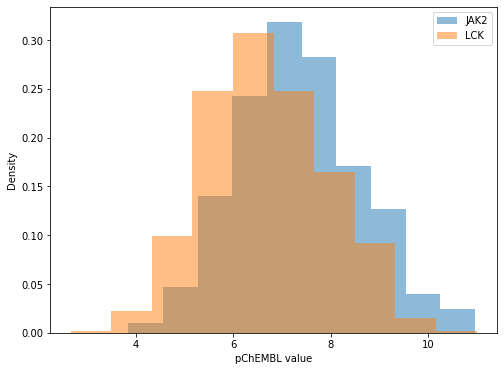

In [468]:
plt.figure(figsize=(8,6))
plt.hist(jak2_data_clean["pchembl_value_mean"], density=True, label="JAK2", alpha=0.5)
plt.hist(lck_data_clean["pchembl_value_mean"], density=True, label="LCK", alpha=0.5)
plt.legend()
plt.xlabel("pChEMBL value")
plt.ylabel("Density")
plt.show()

### PPAR/A/D/G overlap

In [119]:
chembl_ppara_data = get_chembl_assay_data_from_targets(target_uniprot_id="Q07869", uniprot_map=uniprot_map)
chembl_ppard_data = get_chembl_assay_data_from_targets(target_uniprot_id="Q03181", uniprot_map=uniprot_map)
chembl_pparg_data = get_chembl_assay_data_from_targets(target_uniprot_id="P37231", uniprot_map=uniprot_map)

In [135]:
cols = ['chembl_id', 'relation', 'type', 'value', 'pchembl_value', 'units', 'canonical_smiles']
active_overlaps_ppar_df = chembl_ppara_data[chembl_ppara_data["pchembl_value"] > 7][cols].merge(chembl_ppard_data[chembl_ppard_data["pchembl_value"] > 8][cols],on='canonical_smiles').merge(chembl_pparg_data[chembl_pparg_data["pchembl_value"] > 8][cols],on='canonical_smiles')


In [136]:
active_overlaps_ppar_df["canonical_smiles"].unique()

array(['CCCc1c(OCCCSc2ccc(CC(=O)O)cc2Cl)ccc2c(-c3ccccc3)coc12',
       'CCCc1c(OCCCSc2ccc(CC(=O)O)cc2Cl)ccc2c(-c3ccccc3)noc12',
       'CCCc1c(OCCCCOc2cccc(CC(=O)O)c2)ccc2c(-c3ccccc3)noc12'],
      dtype=object)

In [170]:
ppara_data_clean = group_clean_data(chembl_ppara_data, target_name='PPARa')
ppard_data_clean = group_clean_data(chembl_ppard_data, target_name='PPARd')
pparg_data_clean = group_clean_data(chembl_pparg_data, target_name='PPARg')

ppar_comb = pd.concat([ppara_data_clean, ppard_data_clean, pparg_data_clean], ignore_index=True)
ppar_comb.to_csv("Benchmarking_Tasks/Task2/ppar_a_d_g_data.csv", index=False)


In [171]:
print("Number of compounds for PPARa with unique activity data:", len(ppara_data_clean[["pchembl_value_mean", "canonical_smiles"]].drop_duplicates()))
print("Number of active compounds (pChEMBL > 8) for PPARa with unique activity data:", len(ppara_data_clean[ppara_data_clean["pchembl_value_mean"] > 8][["pchembl_value_mean", "canonical_smiles"]].drop_duplicates()))
print("Number of in active compounds (pChEMBL < 5) for PPARa with unique activity data:", len(ppara_data_clean[ppara_data_clean["pchembl_value_mean"] < 5][["pchembl_value_mean", "canonical_smiles"]].drop_duplicates()))
print('\n')
print("Number of compounds for PPARd with unique activity data:", len(ppard_data_clean[["pchembl_value_mean", "canonical_smiles"]].drop_duplicates()))
print("Number of active compounds (pChEMBL > 8) for PPARd with unique activity data:", len(ppard_data_clean[ppard_data_clean["pchembl_value_mean"] > 8][["pchembl_value_mean", "canonical_smiles"]].drop_duplicates()))
print("Number of in active compounds (pChEMBL < 5) for PPARd with unique activity data:", len(ppard_data_clean[ppard_data_clean["pchembl_value_mean"] < 5][["pchembl_value_mean", "canonical_smiles"]].drop_duplicates()))
print('\n')
print("Number of compounds for PPARg with unique activity data:", len(pparg_data_clean[["pchembl_value_mean", "canonical_smiles"]].drop_duplicates()))
print("Number of active compounds (pChEMBL > 8) for PPARg with unique activity data:", len(pparg_data_clean[pparg_data_clean["pchembl_value_mean"] > 8][["pchembl_value_mean", "canonical_smiles"]].drop_duplicates()))
print("Number of in active compounds (pChEMBL < 5) for PPARg with unique activity data:", len(pparg_data_clean[pparg_data_clean["pchembl_value_mean"] < 5][["pchembl_value_mean", "canonical_smiles"]].drop_duplicates()))

Number of compounds for PPARa with unique activity data: 2439
Number of active compounds (pChEMBL > 8) for PPARa with unique activity data: 138
Number of in active compounds (pChEMBL < 5) for PPARa with unique activity data: 239


Number of compounds for PPARd with unique activity data: 1502
Number of active compounds (pChEMBL > 8) for PPARd with unique activity data: 245
Number of in active compounds (pChEMBL < 5) for PPARd with unique activity data: 79


Number of compounds for PPARg with unique activity data: 3656
Number of active compounds (pChEMBL > 8) for PPARg with unique activity data: 318
Number of in active compounds (pChEMBL < 5) for PPARg with unique activity data: 269


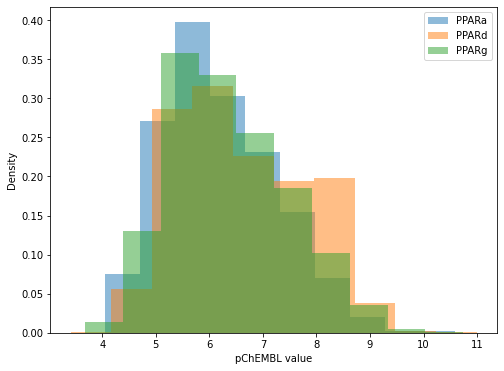

In [467]:
plt.figure(figsize=(8,6))
plt.hist(ppara_data_clean["pchembl_value_mean"], density=True, label="PPARa", alpha=0.5)
plt.hist(ppard_data_clean["pchembl_value_mean"], density=True, label="PPARd", alpha=0.5)
plt.hist(pparg_data_clean["pchembl_value_mean"], density=True, label="PPARg", alpha=0.5)
plt.legend()
plt.xlabel("pChEMBL value")
plt.ylabel("Density")
plt.show()

### Shikimate kinase (H. pylori not 1zyu)

In [36]:
shik_kinase_data = get_chembl_assay_data_from_targets(target_uniprot_id="P56073", uniprot_map=uniprot_map)

In [37]:
shik_data_clean = group_clean_data(shik_kinase_data, target_name='Shik kinase')

In [38]:
shik_data_clean

,canonical_smiles,pchembl_value_mean,pchembl_value_stddev,target
0,COc1cc(C=O)ccc1OCc1ccccc1COc1ccc(/C=C2/SC(=S)N...,5.150,0.162481,Shik kinase
1,COc1cccc(CO[C@@H]2CC(C(=O)O)=C[C@@H](O)[C@H]2O)c1,6.000,NaN,Shik kinase
2,Cc1ccc(CO[C@@H]2CC(C(=O)O)=C[C@@H](O)[C@H]2O)cc1,4.960,NaN,Shik kinase
3,Cc1cccc(CO[C@@H]2CC(C(=O)O)=C[C@@H](O)[C@H]2O)c1,5.680,NaN,Shik kinase
4,O=C(O)C1=C[C@@H](O)[C@@H](O)[C@H](OCc2ccc3cccc...,5.750,NaN,Shik kinase
5,O=C(O)C1=C[C@@H](O)[C@@H](O)[C@H](OCc2ccc3sccc...,6.250,NaN,Shik kinase
6,O=C(O)C1=C[C@@H](O)[C@@H](O)[C@H](OCc2cccc(F)c...,5.890,NaN,Shik kinase
7,O=C(O)C1=C[C@@H](O)[C@@H](O)[C@H](OCc2ccccc2)C1,5.520,NaN,Shik kinase
8,O=C(O)C1=C[C@@H](O)[C@@H](O)[C@H](n2cc(COc3ccc...,4.170,NaN,Shik kinase
9,O=C(O)C1=C[C@@H](O)[C@@H](O)[C@H](n2cc(Cc3cccc...,4.020,NaN,Shik kinase


In [174]:
shik_data_clean.to_csv("Benchmarking_Tasks/Task2/shik_data.csv", index=False)

In [39]:
print("Number of compounds for shik with unique activity data:", len(shik_data_clean[["pchembl_value_mean", "canonical_smiles"]].drop_duplicates()))
print("Number of active compounds (pChEMBL > 8) for shik with unique activity data:", len(shik_data_clean[shik_data_clean["pchembl_value_mean"] > 7][["pchembl_value_mean", "canonical_smiles"]].drop_duplicates()))
print("Number of in active compounds (pChEMBL < 5) for shik with unique activity data:", len(shik_data_clean[shik_data_clean["pchembl_value_mean"] < 5][["pchembl_value_mean", "canonical_smiles"]].drop_duplicates()))

Number of compounds for shik with unique activity data: 13
Number of active compounds (pChEMBL > 8) for shik with unique activity data: 0
Number of in active compounds (pChEMBL < 5) for shik with unique activity data: 4


## Task 3

### COVID-19 Moonshot

In [279]:
# From https://github.com/postera-ai/COVID_moonshot_submissions/tree/master
df_covid_HTS_hits = pd.read_csv("Benchmarking_Tasks/Task3/COVID_Moonshot/weizmann_HTS_900_hits_3X_validation.csv")
df_covid_HTS_doseresponse_val = pd.read_csv("Benchmarking_Tasks/Task3/COVID_Moonshot/weizmann_HTS_128_mol_DR.csv")
df_fragalysis_structures = pd.read_csv("Benchmarking_Tasks/Task3/COVID_Moonshot/fragalysis_structures.csv")
df_PDB_structures = pd.read_csv("Benchmarking_Tasks/Task3/COVID_Moonshot/other_PDB_structures.csv")

In [428]:
# 128 confirmed hits from 885 hits
covid_conf_hits = df_covid_HTS_doseresponse_val[["Molecule Name", "SMILES"]].drop_duplicates()

# Remove salts and stereochemistry
covid_conf_hits = clean_mols(input_df=covid_conf_hits)

# Check whether any of these are crystallised with Mpro
df_fragalysis_structures = clean_mols(input_df=df_fragalysis_structures)
df_PDB_structures = clean_mols(input_df=df_PDB_structures)

# Tag crystallised hits
covid_conf_hits_tagged = covid_conf_hits.merge(df_fragalysis_structures, how='left', on='SMILES_clean').merge(df_PDB_structures, how='left', on=['SMILES_clean', 'ORIGIN', 'structure_ID'])

covid_conf_hits_tagged[["Molecule Name", "SMILES_x", "SMILES_clean", "ORIGIN", "structure_ID"]].to_csv("Benchmarking_Tasks/Task3/COVID_Moonshot/confirmed_hits_SMILES_structure_tagged.csv", index=False)

RDKit ERROR: [20:51:16] SMILES Parse Error: syntax error while parsing: Cbz-Val-Asn-Ser-Thr-Leu-Gln-CMK
RDKit ERROR: [20:51:16] SMILES Parse Error: Failed parsing SMILES 'Cbz-Val-Asn-Ser-Thr-Leu-Gln-CMK' for input: 'Cbz-Val-Asn-Ser-Thr-Leu-Gln-CMK'
RDKit ERROR: [20:51:16] SMILES Parse Error: syntax error while parsing: ACE-SER-ALA-VAL-ALC-HIS-H
RDKit ERROR: [20:51:16] SMILES Parse Error: Failed parsing SMILES 'ACE-SER-ALA-VAL-ALC-HIS-H' for input: 'ACE-SER-ALA-VAL-ALC-HIS-H'


In [304]:
covid_conf_hits_tagged[covid_conf_hits_tagged["ORIGIN"].notna()]

,Molecule Name,SMILES_x,SMILES_clean,SMILES_y,CID,structure_ID,structure_LINK_x,ORIGIN,structure_LINK_y,SMILES
3,PCM-0220020,CC1=C(N2C=CC=CC2=C1C(=O)CCl)C(=O)C1=CC=C(F)C=C1,Cc1c(C(=O)CCl)c2ccccn2c1C(=O)c1ccc(F)cc1,CC=1C(C(=O)CCl)=C2C=CC=CN2C1C(=O)C=3C=CC(F)=CC3,TAT-ENA-80bfd3e5-4,x11590,https://fragalysis.diamond.ac.uk/viewer/react/...,MOONSHOT,NaN,NaN
9,PCM-0219667,CC1=CC(C(=O)CCl)=C(C)N1NC(=O)C1=NNC(=O)C2=C1C=...,Cc1cc(C(=O)CCl)c(C)n1NC(=O)c1n[nH]c(=O)c2ccccc12,CC1=CC(C(=O)CCl)=C(C)N1NC(=O)C2=NNC(=O)C=3C=CC...,TAT-ENA-80bfd3e5-37,x11587,https://fragalysis.diamond.ac.uk/viewer/react/...,MOONSHOT,NaN,NaN
13,PCM-0219639,CSC1=C(C#N)C2(CCCCC2)C(C#N)=C(NC(=O)CCl)N1,CSC1=C(C#N)C2(CCCCC2)C(C#N)=C(NC(=O)CCl)N1,CSC1=C(C#N)C2(CCCCC2)C(=C(NC(=O)CCl)N1)C#N,TAT-ENA-80bfd3e5-7,x11579,https://fragalysis.diamond.ac.uk/viewer/react/...,MOONSHOT,NaN,NaN
56,PCM-0177041,CC(C)OCCCN(CC1=CC=CO1)C(=O)NC1=CN(C)C(=O)C2=CC...,CC(C)OCCCN(Cc1ccco1)C(=O)Nc1cn(C)c(=O)c2ccccc12,CC(C)OCCCN(CC1=CC=CO1)C(=O)NC2=CN(C)C(=O)C=3C=...,MAT-POS-b5746674-38,x12350,https://fragalysis.diamond.ac.uk/viewer/react/...,MOONSHOT,NaN,NaN


### CSAR 2014

#### fXa

In [18]:
# Compounds crystallised: GTC000006, GTC000101, GTC000102
chrom_assay_df = pd.read_csv("Benchmarking_Tasks/Task3/CSAR2014/GSK_fXa/From_GSK_used/chrom-c.csv")
chrom_assay_df["pIC50"] = chrom_assay_df.apply(lambda row: -math.log(row["IC50"]*(10**-6), 10), axis=1)
chrom_assay_df["dataset"] = "Chrom_Assay"

flint1_assay_df = pd.read_csv("Benchmarking_Tasks/Task3/CSAR2014/GSK_fXa/From_GSK_used/flint1-c.csv")
flint1_assay_df = flint1_assay_df.rename(columns={"PIC50": "pIC50"})
flint1_assay_df["dataset"] = "Flint1_Assay"

flint2_assay_df = pd.read_csv("Benchmarking_Tasks/Task3/CSAR2014/GSK_fXa/From_GSK_used/flint2-c.csv")
flint2_assay_df = flint2_assay_df[flint2_assay_df["IC50_MOD"].isna()]
flint2_assay_df["pIC50"] = flint2_assay_df.apply(lambda row: -math.log(row["IC50"]*(10**-6), 10), axis=1)
flint2_assay_df["dataset"] = "Flint2_Assay"

flinta_assay_df = pd.read_csv("Benchmarking_Tasks/Task3/CSAR2014/GSK_fXa/From_GSK_used/flinta-c.csv")
flinta_assay_df = flinta_assay_df.rename(columns={"PXC50": "pIC50"})
flinta_assay_df["dataset"] = "FlintA_Assay"

fp_assay_df = pd.read_csv("Benchmarking_Tasks/Task3/CSAR2014/GSK_fXa/From_GSK_used/fp-c.csv")
fp_assay_df = fp_assay_df.rename(columns={"PXC50": "pIC50"})
fp_assay_df["dataset"] = "FP_Assay"

# Combine all assays and join with SMILES
fxa_all_assays = pd.concat([chrom_assay_df,flint1_assay_df,flint2_assay_df,flinta_assay_df,fp_assay_df])
fxa_all_assays = fxa_all_assays.rename(columns={"GTC_NUMBER": "gtcregno"})
gtc_to_smiles = pd.read_csv("Benchmarking_Tasks/Task3/CSAR2014/GSK_fXa/From_GSK_used/gtc-smiles.csv")
fxa_all_assays_smi = fxa_all_assays.merge(gtc_to_smiles, how="inner", on="gtcregno")

In [65]:
# Group by pIC50 and keep those within -05 to 0.5 stddev
df_grouped_fxa = fxa_all_assays_smi.groupby(['gtcregno', 'dataset'], as_index=False).agg({'pIC50':['mean','std'],'smiles':'first'})
df_grouped_fxa.columns = ['gtcregno', 'dataset', 'pIC50'+'_mean', 'pIC50'+'_stddev','smiles']
df_grouped_fxa = df_grouped_fxa.reindex(columns=sorted(df_grouped_fxa.columns))

# Tag and remove large stddevs 
df_grouped_fxa["Pass stddev check"] = ((df_grouped_fxa['pIC50'+'_stddev'] <= 0.5) & (df_grouped_fxa['pIC50'+'_stddev'] >= -0.5)) | (df_grouped_fxa['pIC50'+'_stddev'].isna())
df_grouped_fxa = df_grouped_fxa[df_grouped_fxa["Pass stddev check"] == True]

# Add crystallised tag
crystallised_cmpds = ['GTC000006', 'GTC000101', 'GTC000102']
df_grouped_fxa["Compound crystallised with protein"] = df_grouped_fxa["gtcregno"].str[:-1].isin(crystallised_cmpds)

df_grouped_fxa.to_csv("Benchmarking_Tasks/Task3/CSAR2014/fXa_cmpds.csv", index=False)

#### SYK

In [457]:
# Compounds crystallised: GTC000222, GTC000223, GTC000224, GTC000225, GTC000226, GTC000233, GTC000249, GTC000250
syk_assay_df = pd.read_csv("Benchmarking_Tasks/Task3/CSAR2014/GSK_Syk/syk-final-submission/gtc-pic50.csv")
syk_assay_df = syk_assay_df[syk_assay_df["PXC50_MOD"].isna()]
syk_assay_df = syk_assay_df.rename(columns={"CMPD_NUMBER": "gtcnum"})
syk_gtc_to_smiles = pd.read_csv("Benchmarking_Tasks/Task3/CSAR2014/GSK_Syk/syk-final-submission/gtc-smiles.csv")

# Merge with SMILES
syk_assay_df_smi = syk_assay_df.merge(syk_gtc_to_smiles, how="inner", on="gtcnum")

# Get mean and stddev of pIC50 data
df_grouped_syk = syk_assay_df_smi.groupby(['gtcnum'], as_index=False).agg({'PXC50':['mean','std'],'SMILES':'first'})
df_grouped_syk.columns = ['gtcregno', 'pIC50'+'_mean', 'pIC50'+'_stddev','smiles']
df_grouped_syk = df_grouped_syk.reindex(columns=sorted(df_grouped_syk.columns))

# Tag any large stddevs 
df_grouped_syk["Pass stddev check"] = ((df_grouped_syk['pIC50'+'_stddev'] <= 0.5) & (df_grouped_syk['pIC50'+'_stddev'] >= -0.5)) | (df_grouped_syk['pIC50'+'_stddev'].isna())

# Add crystallised tag
crystallised_cmpds_syk = ['GTC000222', 'GTC000223', 'GTC000224', 'GTC000225', 'GTC000226', 'GTC000233', 'GTC000249', 'GTC000250']
df_grouped_syk["Compound crystallised with protein"] = df_grouped_syk["gtcregno"].str[:-1].isin(crystallised_cmpds_syk)

df_grouped_syk.to_csv("Benchmarking_Tasks/Task3/CSAR2014/syk_cmpds.csv", index=False)


### TrmD

In [462]:
# All crystal structures have active compounds in structures
trmd_assay_crystal_df = pd.read_csv("Benchmarking_Tasks/Task3/CSAR2014/GSK_trmd/trmd-sub1-final/gtc-smiles-pic50-n-stdev.csv")
trmd_assay_crystal_df = trmd_assay_crystal_df.rename(columns={"gctnum": "gtcregno", "SMILES":"smiles", "pic50":"pIC50_mean", "stdev":"pIC50_stddev"})
trmd_assay_crystal_df.to_csv("Benchmarking_Tasks/Task3/CSAR2014/trmd_cmpds.csv", index=False)

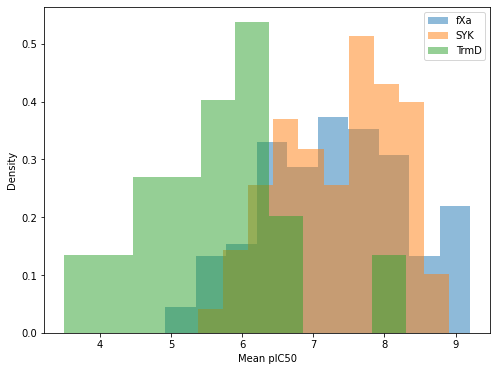

In [466]:
plt.figure(figsize=(8,6))
plt.hist(df_grouped_fxa["pIC50_mean"], density=True, label="fXa", alpha=0.5)
plt.hist(df_grouped_syk["pIC50_mean"], density=True, label="SYK", alpha=0.5)
plt.hist(trmd_assay_crystal_df["pIC50_mean"], density=True, label="TrmD", alpha=0.5)
plt.legend()
plt.xlabel("Mean pIC50")
plt.ylabel("Density")
plt.show()